#  Indexing and searching image based documents (using ColPali with Qdrant)

We can retrieve documents with images such as user guides or old scanned documents. We will use an embedding model for the documents and the queries that supports images. We will also tune the vector database to efficiently store and search these embedding vectors.

Here are the steps:
* [Creating image collection index](#creating-image-collection-index)
* [Searching the image index](#searching-the-image-index)
* [Generating a reply based on the retrieved image](#generate-response-with-the-retrieved-images)

## Visual Improvements

In [1]:
%cd advanced-rag

/content/advanced-rag


In [12]:
# Before installing other requirements, ensure compatible torch and torchvision versions.
# The error indicates torchvision 0.24.0 requires torch 2.9.0, while current torch is 2.4.1.
# We will uninstall existing torch, torchvision, and torchaudio and then install the required compatible versions.
!pip uninstall -y torch torchvision torchaudio
!pip install torch==2.9.0 torchvision==0.24.0+cu121 torchaudio==2.9.0+cu121 -f https://download.pytorch.org/whl/torch_stable.html

!git clone https://github.com/guyernest/advanced-rag.git
%cd advanced-rag
!pip install -q -r requirements.txt

Found existing installation: torch 2.4.1
Uninstalling torch-2.4.1:
  Successfully uninstalled torch-2.4.1
Found existing installation: torchvision 0.24.0+cu126
Uninstalling torchvision-0.24.0+cu126:
  Successfully uninstalled torchvision-0.24.0+cu126
Found existing installation: torchaudio 2.9.0+cu126
Uninstalling torchaudio-2.9.0+cu126:
  Successfully uninstalled torchaudio-2.9.0+cu126
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==2.9.0+cu121 (from versions: 2.2.0, 2.2.0+cpu, 2.2.0+cpu.cxx11.abi, 2.2.0+cu118, 2.2.0+cu121, 2.2.0+rocm5.6, 2.2.0+rocm5.7, 2.2.1, 2.2.1+cpu, 2.2.1+cpu.cxx11.abi, 2.2.1+cu118, 2.2.1+cu121, 2.2.1+rocm5.6, 2.2.1+rocm5.7, 2.2.2, 2.2.2+cpu, 2.2.2+cpu.cxx11.abi, 2.2.2+cu118, 2.2.2+cu121, 2.2.2+rocm5.6, 2.2.2+rocm5.7, 2.3.0, 2.3.0+cpu, 2.3.0+cpu.cxx11.abi, 2.3.0+cu118, 2.3.0+cu121, 2.3.0+rocm5.7, 2.3.0+rocm6.0, 2.3.1, 2.3.1+cpu, 2.3.1+cpu.cxx11.abi, 2.3.1+cu118, 2.3.1+cu121

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Driver Licence Savi 2024.pdf to Driver Licence Savi 2024.pdf


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
from rich.console import Console
from rich_theme_manager import Theme, ThemeManager
import pathlib

theme_dir = pathlib.Path("themes")
theme_manager = ThemeManager(theme_dir=theme_dir)
dark = theme_manager.get("dark")

# Create a console with the dark theme
console = Console(theme=dark)

In [3]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

## Creating image collection index

### Converting PDF files into images

We don't want to rely on text extraction from the PDF files, and we want to focus on the visual aspects of the pages.

In [4]:
import os
from pdf2image import convert_from_path


def convert_pdfs_to_images(pdf_folder):
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
    all_images = {}

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path)
        all_images[pdf_file] = images

    return all_images

In [5]:
# all_images = convert_pdfs_to_images("data/ikea/")
# Install poppler-utils
!apt-get install poppler-utils

all_images = convert_pdfs_to_images("data/license/")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.12).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [6]:
console.print(all_images)

{
    'Driver Licence Savi 2024.pdf': [
        <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1700x2200 at 0x78ED2ECD1640>
    ]
}

IndexError: list index out of range

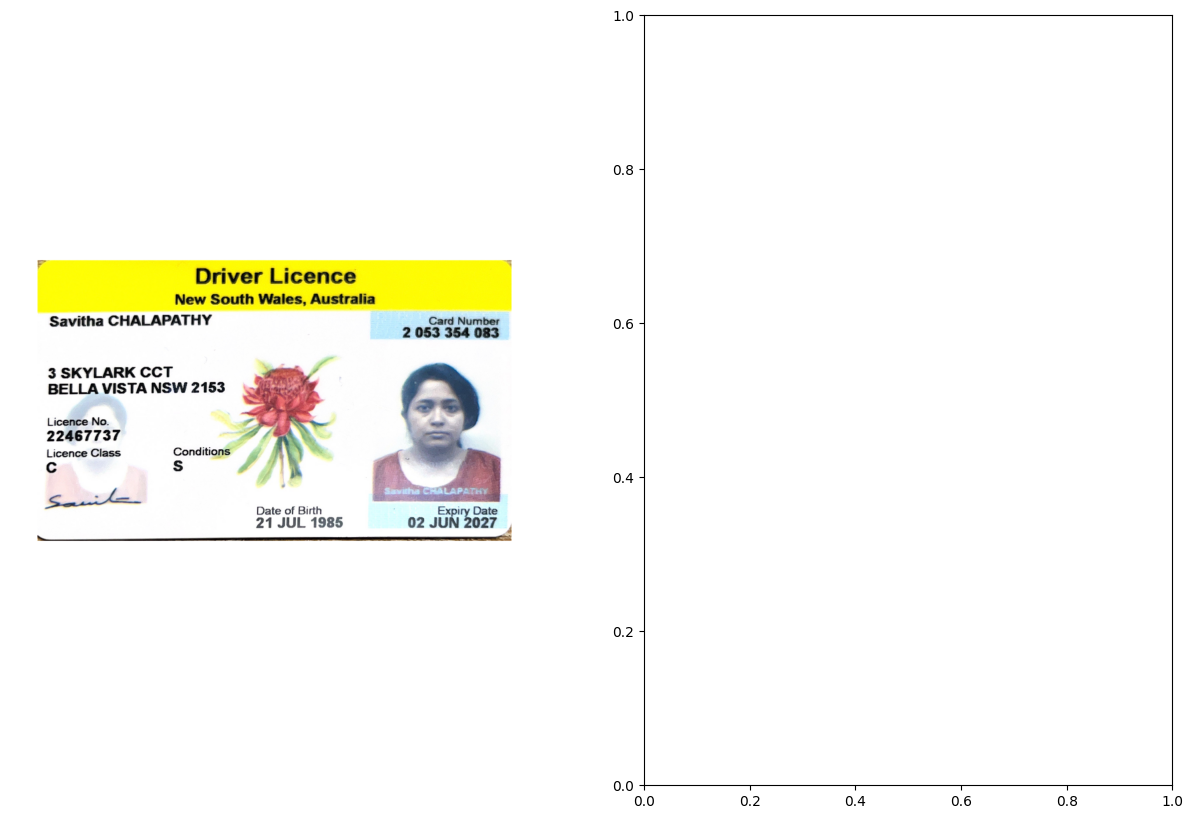

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

first_pdf_key = next(iter(all_images))
for i, ax in enumerate(axes.flat):
    img = all_images[first_pdf_key][i]
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [8]:
from colpali_engine.models import ColPali, ColPaliProcessor
import torch


# Initialize ColPali model and processor
model_name = (
    "vidore/colpali-v1.2"  # Use the latest version available
)
colpali_model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",  # Use "cuda:0" for GPU, "cpu" for CPU, or "mps" for Apple Silicon
)
colpali_processor = ColPaliProcessor.from_pretrained(
    "vidore/colpaligemma-3b-pt-448-base"
)

adapter_config.json:   0%|          | 0.00/750 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/862M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

In [ ]:
console.print(colpali_model)

ColPali(
  (model): PaliGemmaForConditionalGeneration(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(1024, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-26): 27 x SiglipEncoderLayer(
              (self_attn): SiglipSdpaAttention(
                (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
              )
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (mlp): SiglipMLP(
                (activation_fn): PytorchGELUTanh()
                (fc1): Linear(in_features=1152, out_features=4304, bias=True)
                (fc2): Linear(in_features=4304, out_features=1152, bias=True)
              )
              (layer_norm2): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            )
          )
        )
        (post_layernorm): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
      )
    )
    (multi_modal_projector): PaliGemmaMultiModalProjector(
      (linear): Linear(in_features=1152, out_features=2048, bias=True)
    )
    (language_model): GemmaForCausalLM(
      (model): GemmaModel(
        (embed_tokens): Embedding(257216, 2048, padding_idx=0)
        (layers): ModuleList(
          (0-17): 18 x GemmaDecoderLayer(
            (self_attn): GemmaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=256, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=256, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (v_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=256, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=256, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (o_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
        

In [ ]:
sample_image = all_images[first_pdf_key][0]
with torch.no_grad():
    sample_batch = colpali_processor.process_images([sample_image]).to(
        colpali_model.device
    )
    sample_embedding = colpali_model(**sample_batch)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [ ]:
console.print(sample_embedding)

tensor([[[ 0.0608,  0.0535,  0.1250,  ...,  0.0030,  0.0559, -0.0491],
         [-0.0967,  0.0967,  0.2793,  ...,  0.0135, -0.1357, -0.0192],
         [ 0.0815,  0.0845,  0.1680,  ...,  0.1172,  0.0791,  0.0491],
         ...,
         [-0.0008, -0.0454,  0.0820,  ..., -0.0069, -0.1670,  0.0464],
         [-0.0210,  0.0425,  0.1299,  ...,  0.0101, -0.0820,  0.0801],
         [-0.0383,  0.0991,  0.3027,  ...,  0.0325, -0.0442,  0.0464]]],
       device='mps:0', dtype=torch.bfloat16)

In [ ]:
from rich.table import Table

table = Table(title="Document Embedding")
table.add_column("Documents", style="cyan", no_wrap=True)
table.add_column("Tokens", style="bright_yellow")
table.add_column("Vector Size", style="green")

table.add_row(
    str(sample_embedding.shape[0]),
    str(sample_embedding.shape[1]),
    str(sample_embedding.shape[2])
)

console.print(table)

         Document Embedding         
┏━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Documents ┃ Tokens ┃ Vector Size ┃
┡━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━┩
│ 1         │ 1030   │ 128         │
└───────────┴────────┴─────────────┘

In [ ]:
from qdrant_client import QdrantClient

qdrant_client = QdrantClient(
    ":memory:"
)  # Use ":memory:" for in-memory database or "path/to/db" for persistent storage

In [ ]:
vector_size = sample_embedding.shape[2]

In [ ]:
from qdrant_client.http import models

multi_vector_params = models.VectorParams(
    size=vector_size,
    distance=models.Distance.COSINE,
    multivector_config=models.MultiVectorConfig(
        comparator=models.MultiVectorComparator.MAX_SIM
    ),
)

### Reducing vector memory using Quantization

We can define a `ScalarQuantizationConfig` and pass it when creating the collection. On the server side, Qdrant will convert the vectors to 8-bit integers, reducing the memory footprint and speeding up the search process. You can also switch on or off the `always_ram` parameter, keeping the vectors in RAM. This will increase performance at the cost of memory usage.

In [ ]:
scalar_quant = models.ScalarQuantizationConfig(
    type=models.ScalarType.INT8,
    quantile=0.99,
    always_ram=False,
)

In [ ]:
collection_name="user-guides"

qdrant_client.recreate_collection(
    collection_name=collection_name,  # the name of the collection
    on_disk_payload=True,  # store the payload on disk
    optimizers_config=models.OptimizersConfigDiff(
        indexing_threshold=100
    ),  # it can be useful to swith this off when doing a bulk upload and then manually trigger the indexing once the upload is done
    vectors_config=models.VectorParams(
        size=vector_size,
        distance=models.Distance.COSINE,
        multivector_config=models.MultiVectorConfig(
            comparator=models.MultiVectorComparator.MAX_SIM
        ),
        quantization_config=models.ScalarQuantization(
            scalar=scalar_quant,
        ),
    ),
)

True

### Upserting the encoded images into the vector database

We define a helper function to upload points to Qdrant via the client. We use the stamina library to enable retries in case of network issues

In [ ]:
import stamina

@stamina.retry(on=Exception, attempts=3)
def upsert_to_qdrant(batch):
    try:
        qdrant_client.upsert(
            collection_name=collection_name,
            points=points,
            wait=False,
        )
    except Exception as e:
        print(f"Error during upsert: {e}")
        return False
    return True

We will now upload the vectors to qdrant. We do this by creating batches of data, passing it through the ColPali model and then adding the embeddings to a Qdrant `PointStruct`.

In [ ]:
import uuid
from tqdm import tqdm

batch_size = 2  # Adjust based on your GPU memory constraints

total_images = sum(len(images) for images in all_images.values())

# Use tqdm to create a progress bar
with tqdm(total=total_images, desc="Indexing Progress") as pbar:
    for doc_id, pdf_file in enumerate(all_images.keys()):
        for i in range(0, len(all_images[pdf_file]), batch_size):
            images = all_images[pdf_file][i : i + batch_size]

            # Process and encode images
            with torch.no_grad():
                batch_images = colpali_processor.process_images(images).to(
                    colpali_model.device
                )
                image_embeddings = colpali_model(**batch_images)

            # Prepare points for Qdrant
            points = []
            for j, embedding in enumerate(image_embeddings):
                unique_id = str(uuid.uuid5(uuid.NAMESPACE_DNS, f"{doc_id}.{i + j}"))
                # Convert the embedding to a list of vectors
                multivector = embedding.cpu().float().numpy().tolist()
                points.append(
                    models.PointStruct(
                        id=unique_id,
                        vector=multivector,  # This is now a list of vectors
                        payload={
                            "doc": pdf_file,
                            "page": i+j+1
                        },  # can also add other metadata/data
                    )
                )
            # Upload points to Qdrant
            try:
                upsert_to_qdrant(points)
            # clown level error handling here 🤡
            except Exception as e:
                print(f"Error during upsert: {e}")
                continue

            # Update the progress bar
            pbar.update(batch_size)

print("Indexing complete!")

Indexing Progress: 100%|██████████| 8/8 [00:38<00:00,  4.78s/it]

Indexing complete!


If you had the indexing off during the upload you can trigger an index by setting a lower indexing threshold.

In [ ]:
qdrant_client.update_collection(
    collection_name=collection_name,
    optimizer_config=models.OptimizersConfigDiff(indexing_threshold=10),
)

False

In [ ]:
console.print(
    qdrant_client
    .get_collection(collection_name)
)

CollectionInfo(
    status=<CollectionStatus.GREEN: 'green'>,
    optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>,
    vectors_count=None,
    indexed_vectors_count=0,
    points_count=8,
    segments_count=1,
    config=CollectionConfig(
        params=CollectionParams(
            vectors=VectorParams(
                size=128,
                distance=<Distance.COSINE: 'Cosine'>,
                hnsw_config=None,
                quantization_config=ScalarQuantization(
                    scalar=ScalarQuantizationConfig(
                        type=<ScalarType.INT8: 'int8'>,
                        quantile=0.99,
                        always_ram=False
                    )
                ),
                on_disk=None,
                datatype=None,
                multivector_config=MultiVectorConfig(comparator=<MultiVectorComparator.MAX_SIM: 'max_sim'>)
            ),
            shard_number=None,
            sharding_method=None,
            replication_factor=None,
            write_consistency_factor=None,
            read_fan_out_factor=None,
            on_disk_payload=None,
            sparse_vectors=None
        ),
        hnsw_config=HnswConfig(
            m=16,
            ef_construct=100,
            full_scan_threshold=10000,
            max_indexing_threads=0,
            on_disk=None,
            payload_m=None
        ),
        optimizer_config=OptimizersConfig(
            deleted_threshold=0.2,
            vacuum_min_vector_number=1000,
            default_segment_number=0,
            max_segment_size=None,
            memmap_threshold=None,
            indexing_threshold=20000,
            flush_interval_sec=5,
            max_optimization_threads=1
        ),
        wal_config=WalConfig(wal_capacity_mb=32, wal_segments_ahead=0),
        quantization_config=None
    ),
    payload_schema={}
)

In [ ]:
console.print(
    qdrant_client
    .scroll(
        collection_name=collection_name,
        limit=20
    )
)

(
    [
        Record(
            id='2d51c088-46a9-509d-816e-cbf4b348233e',
            payload={'doc': 'OpenRun Pro User Guide.pdf', 'page': 3},
            vector=None,
            shard_key=None,
            order_value=None
        ),
        Record(
            id='462685c4-e334-5911-908b-938cfad62d4b',
            payload={'doc': 'OpenRun Pro User Guide.pdf', 'page': 4},
            vector=None,
            shard_key=None,
            order_value=None
        ),
        Record(
            id='59be58f4-0957-5621-bd37-2ac4f836f6b2',
            payload={'doc': 'OpenRun Pro User Guide.pdf', 'page': 5},
            vector=None,
            shard_key=None,
            order_value=None
        ),
        Record(
            id='627cb812-738a-5e70-a04b-a53cb2fdf030',
            payload={'doc': 'OpenRun Pro User Guide.pdf', 'page': 1},
            vector=None,
            shard_key=None,
            order_value=None
        ),
        Record(
            id='64b6d457-fe4f-5775-9e70-6120c9bc52e4',
            payload={'doc': 'OpenRun Pro User Guide.pdf', 'page': 6},
            vector=None,
            shard_key=None,
            order_value=None
        ),
        Record(
            id='6da54e52-f04e-54a1-abbb-a548a77a0dea',
            payload={'doc': 'OpenRun Pro User Guide.pdf', 'page': 2},
            vector=None,
            shard_key=None,
            order_value=None
        ),
        Record(
            id='9ff41a4f-5233-553f-b10a-4c1861a49989',
            payload={'doc': 'OpenRun Pro User Guide.pdf', 'page': 8},
            vector=None,
            shard_key=None,
            order_value=None
        ),
        Record(
            id='a6c1e115-7f15-5940-a876-19dbbf5a4d80',
            payload={'doc': 'OpenRun Pro User Guide.pdf', 'page': 7},
            vector=None,
            shard_key=None,
            order_value=None
        )
    ],
    None
)

## Searching the image index

Once we uploaded the encoded images to the vector database, we can query it.

In [ ]:
# query_text = "How do I answer a call?"
query_text = "Why the led is flashing red and blue?"
with torch.no_grad():
    batch_query = colpali_processor.process_queries([query_text]).to(
        colpali_model.device
    )
    query_embedding = colpali_model(**batch_query)


In [ ]:
console.print(query_embedding.shape)

torch.Size([1, 23, 128])

In [ ]:
# Convert the query embedding to a list of vectors
multivector_query = query_embedding[0].cpu().float().numpy().tolist()

In [ ]:
search_result = qdrant_client.query_points(
    collection_name=collection_name,
    query=multivector_query,
    limit=3,
    timeout=60,
)

In [ ]:
console.print(search_result)

QueryResponse(
    points=[
        ScoredPoint(
            id='2d51c088-46a9-509d-816e-cbf4b348233e',
            version=0,
            score=17.636383532238728,
            payload={'doc': 'OpenRun Pro User Guide.pdf', 'page': 3},
            vector=None,
            shard_key=None,
            order_value=None
        ),
        ScoredPoint(
            id='6da54e52-f04e-54a1-abbb-a548a77a0dea',
            version=0,
            score=16.49336628129387,
            payload={'doc': 'OpenRun Pro User Guide.pdf', 'page': 2},
            vector=None,
            shard_key=None,
            order_value=None
        ),
        ScoredPoint(
            id='59be58f4-0957-5621-bd37-2ac4f836f6b2',
            version=0,
            score=10.817028962656222,
            payload={'doc': 'OpenRun Pro User Guide.pdf', 'page': 5},
            vector=None,
            shard_key=None,
            order_value=None
        )
    ]
)

### Show the search results images

We can display the images that were retrieved by the vector search.

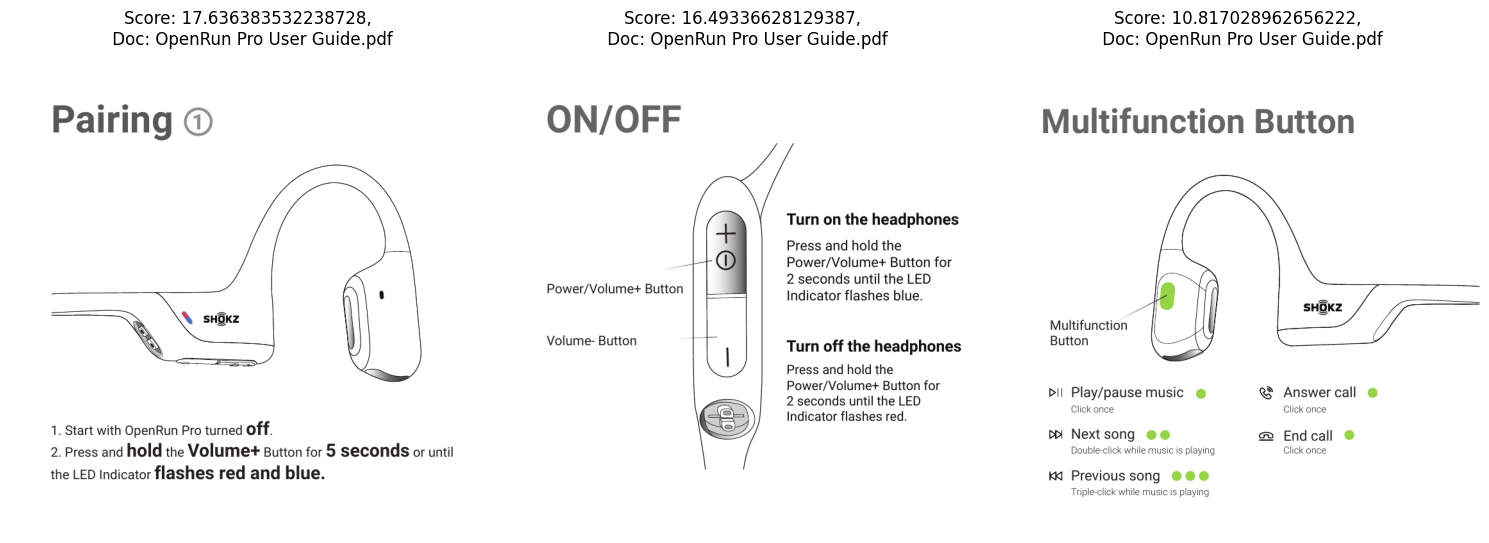

In [ ]:
import matplotlib.pyplot as plt

# Extract the top 3 images from the search result for display
top_images = search_result.points[:6]

# Create a figure with subplots for each image
fig, axs = plt.subplots(1, 3, figsize=(15, 10))

# Iterate over the top images and plot each one
for i, point in enumerate(top_images):
    pdf_file = point.payload.get('doc')
    page_num = int(point.payload.get('page')) - 1
    img = all_images[pdf_file][page_num]
    axs[i].imshow(img)
    axs[i].set_title(f"Score: {point.score}, \n Doc: {pdf_file}")
    axs[i].axis('off')  # Do not display axes for better visualization

plt.tight_layout()
plt.show()

## Generate response with the retrieved image(s)

In the **A**ugmentation step we encode the retrieved image using base64 and send it as part of the prompt to the generation model, alongside the user's query.

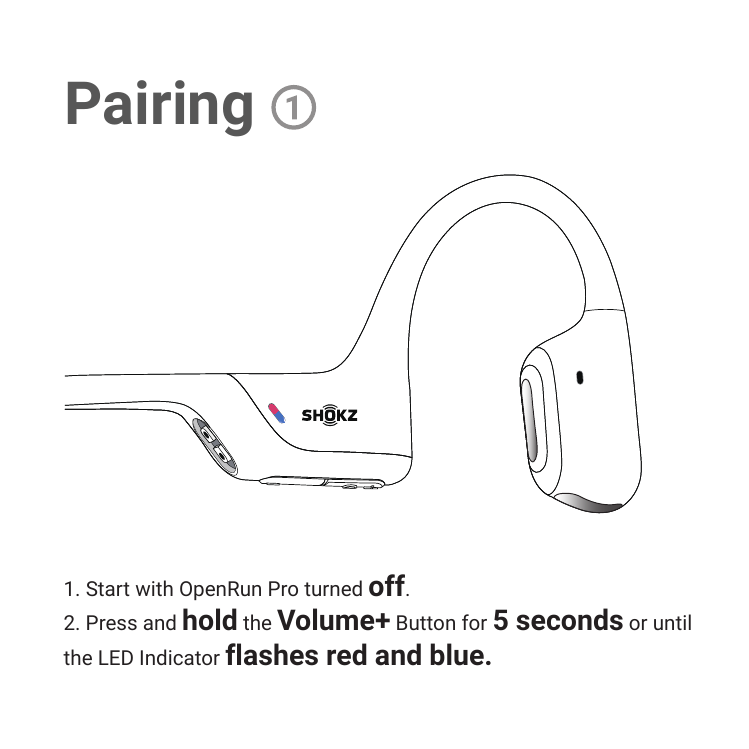

In [ ]:
import base64
from io import BytesIO

top_image = search_result.points[0]
pdf_file = top_image.payload.get('doc')
page_num = int(top_image.payload.get('page')) - 1
image = all_images[pdf_file][page_num]
display(image)

buffered = BytesIO()
image.save(buffered, format="PNG")  # You may choose another format if needed
img_bytes = buffered.getvalue()

image1_media_type = "image/png"

image1_data = base64.standard_b64encode(img_bytes).decode("utf-8")

In [ ]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
import anthropic

client = anthropic.Anthropic()
message = client.messages.create(
    model="claude-3-5-sonnet-20241022",
    max_tokens=1024,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "source": {
                        "type": "base64",
                        "media_type": image1_media_type,
                        "data": image1_data,
                    },
                },
                {
                    "type": "text",
                    "text": query_text
                }
            ],
        }
    ],
)
console.print(message)


Message(
    id='msg_01UVoXsRtCBBpMRBto9D3dvY',
    content=[
        TextBlock(
            text="In this image, the LED is flashing red and blue as part of the Bluetooth pairing process for the 
Shokz OpenRun Pro headphones. This is a common indicator pattern used by many Bluetooth devices to show they've 
entered pairing mode and are ready to connect to a new device. The instructions show that this pairing mode is 
activated by holding the Volume+ button for 5 seconds while the device is turned off. The alternating red and blue 
flash pattern is a standard way for users to visually confirm that the device is in pairing mode and ready to 
connect to their phone, computer, or other Bluetooth-enabled device.",
            type='text'
        )
    ],
    model='claude-3-5-sonnet-20241022',
    role='assistant',
    stop_reason='end_turn',
    stop_sequence=None,
    type='message',
    usage=Usage(input_tokens=750, output_tokens=139)
)